## Spam detection
1. Read dataset and make it in proper format.
2. Encode labels
3. Convert all cases to lower
4. Remove punctuations
5. Remove Stopwords
6. Check stats of messages
7. Convert all texts into vectors
8. Import classifier
9. Train and test
10. Check the accuracy/confusion matrix.

In [1]:
#Importing the libaies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the dataset
df = pd.read_csv("messages.csv",encoding='latin-1')

In [3]:
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [4]:
#Checking the shape of the dataset
print("Shape of the dataset:", df.shape)

Shape of the dataset: (2893, 3)


In [5]:
#Checking for the null values
df.isnull().values.any()

True

In [6]:
#Checkin for the null values in columns
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

Finding:
    1. 62 row are missing in the subject columns that means 62 emails are without subject heading. 
    2. Not drop Nan rows for subject column because we build our model with message and label column

In [7]:
print("Count of label:\n",df['label'].value_counts())

Count of label:
 0    2412
1     481
Name: label, dtype: int64


Note:-  Here in our dataset 1 stands for Spam mail and 0 stands for not a spam mail

In [8]:
#Checking the Ratio of labels
print("Not a Spam Email Ratio i.e. 0 label:",round(len(df[df['label']==0])/len(df['label']),2)*100,"%")
print("Spam Email Ratio that is 1 label:",round(len(df[df['label']==1])/len(df['label']),2)*100,"%")

Not a Spam Email Ratio i.e. 0 label: 83.0 %
Spam Email Ratio that is 1 label: 17.0 %


Finding:-  17% mail are Spam email.

In [9]:
#Creating the new column for length of message column
df['length'] = df.message.str.len()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [10]:
#Converting all messages to lower case
df['message'] = df['message'].str.lower()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


### 2.1 Regular Expressions

Some common regular expression metacharacters - copied from wikipedia
^ Matches the starting position within the string. In line-based tools, it matches the starting position of any line.

. Matches any single character (many applications exclude newlines, and exactly which characters are considered newlines is flavor-, character-encoding-, and platform-specific, but it is safe to assume that the line feed character is included). Within POSIX bracket expressions, the dot character matches a literal dot. For example, a.c matches "abc", etc., but [a.c] matches only "a", ".", or "c".

[ ] A bracket expression. Matches a single character that is contained within the brackets. For example, [abc] matches "a", "b", or "c". [a-z] specifies a range which matches any lowercase letter from "a" to "z". These forms can be mixed: [abcx-z] matches "a", "b", "c", "x", "y", or "z", as does [a-cx-z]. The - character is treated as a literal character if it is the last or the first (after the ^, if present) character within the brackets: [abc-], [-abc]. Note that backslash escapes are not allowed. The ] character can be included in a bracket expression if it is the first (after the ^) character: []abc].

[^ ] Matches a single character that is not contained within the brackets. For example, [^abc] matches any character other than "a", "b", or "c". [^a-z] matches any single character that is not a lowercase letter from "a" to "z". Likewise, literal characters and ranges can be mixed.

$ Matches the ending position of the string or the position just before a string-ending newline. In line-based tools, it matches the ending position of any line.

( ) Defines a marked subexpression. The string matched within the parentheses can be recalled later (see the next entry, \n). A marked subexpression is also called a block or capturing group. BRE mode requires ( ).

\n Matches what the nth marked subexpression matched, where n is a digit from 1 to 9. This construct is vaguely defined in the POSIX.2 standard. Some tools allow referencing more than nine capturing groups.

Matches the preceding element zero or more times. For example, abc matches "ac", "abc", "abbbc", etc. [xyz] matches "", "x", "y", "z", "zx", "zyx", "xyzzy", and so on. (ab)* matches "", "ab", "abab", "ababab", and so on.
{m,n} Matches the preceding element at least m and not more than n times. For example, a{3,5} matches only "aaa", "aaaa", and "aaaaa". This is not found in a few older instances of regexes. BRE mode requires {m,n}.

### Regular Expressions

In [11]:
# Replace email addresses with 'email'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['message'] = df['message'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')

    
# Replace numbers with 'numbr'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [12]:
# Remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'^\s+|\s+?$', '')

In [13]:
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856
1,NaN,lang classification grimes joseph e and barbar...,0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas sa...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [14]:
#Removing the stopwords
import string
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['message'] = df['message'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

In [15]:
# New column (clean_length) after puncuations,stopwords removal
df['clean_length'] = df.message.str.len()
df.head()

,subject,message,label,length,clean_length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856,2179
1,NaN,lang classification grimes joseph e barbara f ...,0,1800,1454
2,query : letter frequencies for text identifica...,posting inquiry sergei atamas satamas umabnet ...,0,1435,1064
3,risk,colleague researching differing degrees risk p...,0,324,210
4,request book information,earlier morning phone friend mine living south...,0,1046,629


In [16]:
#Total length removal
print("Origional Length:",df.length.sum())
print("Cleaned Length:",df.clean_length.sum())
print("Total Words Removed:",(df.length.sum()) - (df.clean_length.sum()))

Origional Length: 9344743
Cleaned Length: 6767857
Total Words Removed: 2576886


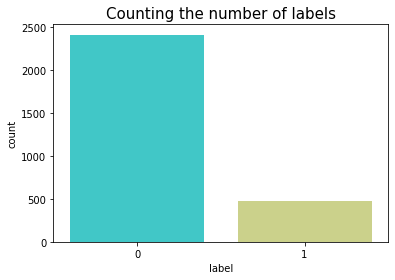

0    2412
1     481
Name: label, dtype: int64


In [17]:
#Rates the overall material and finish of the house.
plt.figure(figsize=(6,4))
sns.countplot(df['label'],palette= 'rainbow')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

print(df.label.value_counts())

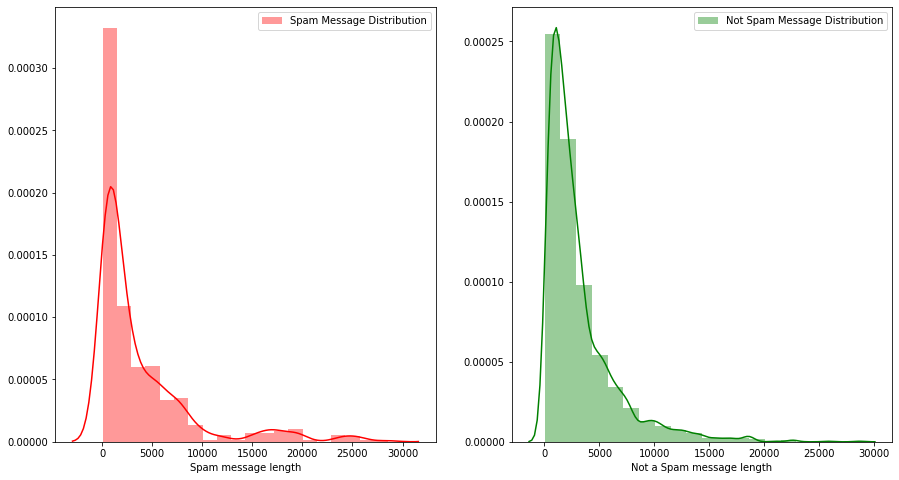

In [18]:
#Message distribution before cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='g')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()

plt.show()

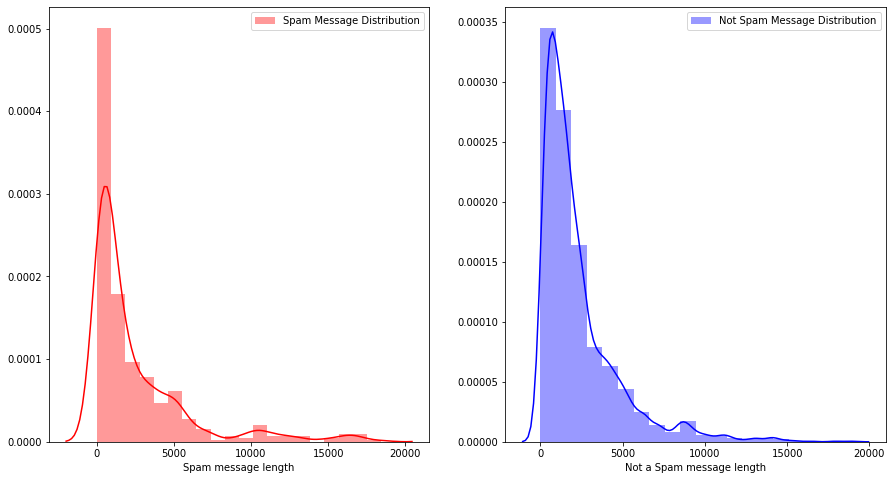

In [19]:
#Message distribution before cleaning
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['clean_length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['clean_length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()

plt.show()

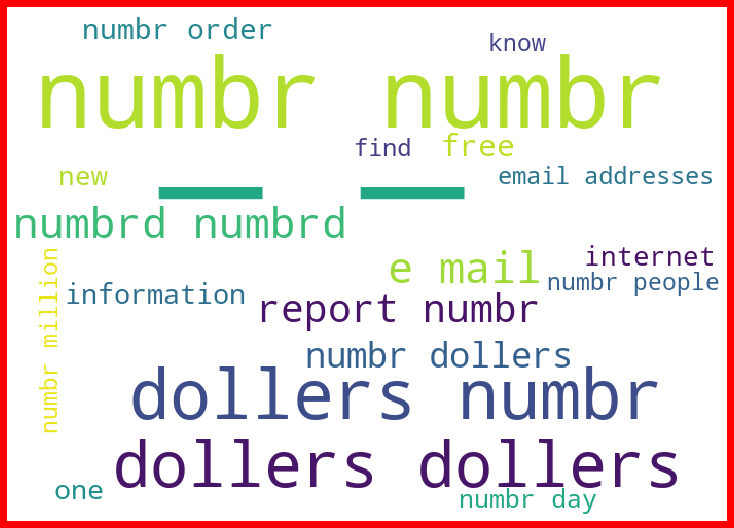

In [21]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


spams = df['message'][df['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

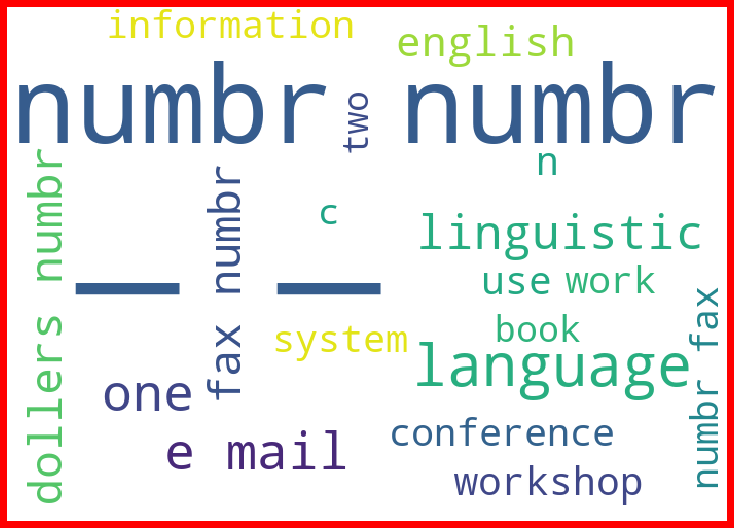

In [22]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


not_spams = df['message'][df['label']==0]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=20).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Converting the text into vectors using TF-IDF

In [23]:
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tf_vec = TfidfVectorizer()

naive = MultinomialNB()

features = tf_vec.fit_transform(df['message'])

X = features
y = df['label']

In [24]:
# Train and predict
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)

naive.fit(X_train,Y_train)

y_pred= naive.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.8342541436464088


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       585
           1       1.00      0.14      0.24       139

    accuracy                           0.83       724
   macro avg       0.91      0.57      0.57       724
weighted avg       0.86      0.83      0.78       724



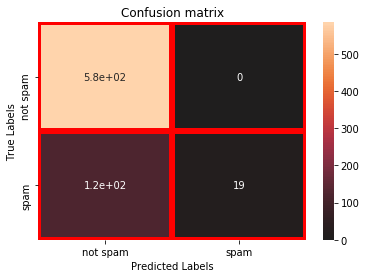

In [26]:
# plot confusion matrix heatmap
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['not spam','spam'])
ax.yaxis.set_ticklabels(['not spam','spam'])
plt.show()

In [27]:
conf_mat

array([[585,   0],
       [120,  19]], dtype=int64)